This Jupyter nootebook is essentially based on functions of the <b>Python Library MNE (https://mne.tools/stable/index.html).</b>

It contains the basic steps for processing EEG data:
* Loading
* Specify montage
* Re-referencing
* Filtering
* Data quality assessment #1: Filtered data
* Event annotations
* Artefact cleaning using Artefact Subspace Reconstructionb (ASR)
* Segmentation / Epoching
* Baseline correction
* Data quality assessment #2: Segment / Epoch
* Time frequency analyses (TFA)
* Saving the results

### ____________________________________________________________________________
### Loading the necessary libraries 

#### EEG specific libraries

In [ ]:
import mne                                             # all the stuff for artefact cleaning, epoching, ERP and TFA computation

#### Libraries for data handling, data display, mathematical computations and file handling

In [19]:
import os                         # operating system related functions
import ipyfilechooser             # interactive file chooser
import numpy as np                # basic mathematical functions
import pandas as pd               # excel-like table functions
import seaborn as sns             # data plotting
import matplotlib.pyplot as plt   # again, data plotting
%matplotlib qt                    
import warnings                   # only to suppress annoying warning messages 
mne.set_log_level("ERROR")        # show only errors (no warnings or information messages)
warnings.simplefilter(action='ignore')

In [20]:
# specific frequency bands
frequencyBands = {"delta": [0.5, 4.0],
                  "theta": [4.0, 8.0],
                  "alpha": [8.0, 11.0],
                  "sigma": [11.0, 15.0],
                  "beta":  [15.0, 30.0],
                  "gamma": [30.0, 35.0]}

# rejection criteria
rejectionCriteria = dict(eeg = 1.5e-4) # 100 µV

# default display scaling, use e-6 for display in microvolts
scal = {'eeg': 1e-4}  

# cap design
easycap_montage = mne.channels.make_standard_montage("easycap-M1")

## (1) Odball experiment

#### 1) Loading data ans set montage

In [21]:
data_folder = "/Volumes/SanDisk/data"
exp_id = "012_dial_4m_bil_20241021"
# load eeg data
path = os.path.join(data_folder, exp_id, "eeg", f"{exp_id}.vhdr")
if os.path.exists(path):
    raw = mne.io.read_raw_brainvision(path, preload = True)
else:
    raw = None
    print(f"EEG data not found in {path}")

# create folder for analysis output
analysis_path = os.path.join(data_folder, exp_id, "eeg", "analysis")
os.makedirs(analysis_path, exist_ok=True)

#### 2) Specify montage<br>3) Re-referencing<br>4) Filtering<br>5) Data quality assessment #1: Filtered data

In [22]:
events, event_id = mne.events_from_annotations(raw)
print(f"Overall number of triggers (including stimtrak): {len(events)}") 
print(f"Number of computer triggers: {len([e for e in events if e[2] != 10001 and  e[2] != 99999 ])} (64 is expected for full experiment)") 

Overall number of triggers (including stimtrak): 1004
Number of computer triggers: 64 (64 is expected for full experiment)


In [23]:
# set used montage
raw.set_montage(easycap_montage,on_missing='ignore')
# # re-referencing to mean
raw_AvgRef = raw.copy()
raw_AvgRef.set_eeg_reference("average")
# band-pass filter
raw_AvgRef_filt = raw_AvgRef.copy().filter(l_freq=1, h_freq = 40)
raw_AvgRef_filt.plot_psd()
raw_AvgRef_filt.info

<Info | 9 non-empty values
 bads: []
 ch_names: C3, F3, Fz, F4, C4
 chs: 5 EEG
 custom_ref_applied: True
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2024-10-21 12:00:34 UTC
 nchan: 5
 projs: []
 sfreq: 1000.0 Hz
>

#### 6) Event annotations

In [24]:
# Discard stimtrak triggers that do not follow immediately after a computer trigger

descriptions = []
onsets = []
durations = []
orig_times = []

last_desc = ""
last_onset = ""
for annotation in raw_AvgRef_filt.annotations:
    if "Push/P" in annotation["description"] and "Stimulus/S" in last_desc:
        if annotation["onset"] - last_onset <= 0.5:
            descriptions.append(last_desc)
            onsets.append(annotation["onset"])
            durations.append(annotation["duration"])
            orig_times.append(annotation["orig_time"])
        else:
            print(f"WARNING: Stimtrak trigger too late at time {annotation['onset']} -- computer trigger at {last_onset}. Skipping trigger.")

    if "Stimulus/S" in annotation["description"] and "Stimulus/S" in last_desc:
        print(f"WARNING: Missing stimtrak trigger at time {last_onset}.")
   
    
    last_desc = annotation["description"]
    last_onset = annotation["onset"]
    
raw_AvgRef_filt_select = raw_AvgRef_filt.copy()
raw_AvgRef_filt_select.set_annotations(mne.Annotations(onset=onsets, duration=durations, description=descriptions))    
print(f"\nNumber of triggers left after adjustments: {len(raw_AvgRef_filt_select.annotations)}")     


Number of triggers left after adjustments: 64


In [25]:
def update_trigger(trigger):
    if trigger[0] == "1":
        new_trigger = "1"
    elif trigger[0] == "3":
        new_trigger = "3"
    elif trigger == "21" or trigger == "23" or trigger == "42" or trigger == "44":
        new_trigger = "2"
    elif trigger == "41" or trigger == "43" or trigger == "22" or trigger == "24":
        new_trigger = "4"
    else:
        print(f"Warning - unexpected trigger number: {trigger}")
    return new_trigger

descriptions = []
onsets = []
durations = []
orig_times = []

for a in raw_AvgRef_filt_select.annotations:
    _, n = a["description"].replace("  "," ").split(" ")
    descriptions.append("Stimulus/S " + update_trigger(n))
    onsets.append(a["onset"])
    durations.append(a["duration"])
    orig_times.append(a["orig_time"])

raw_AvgRef_filt_new = raw_AvgRef_filt_select.copy()
raw_AvgRef_filt_new.set_annotations(mne.Annotations(onset=onsets, duration=durations, description=descriptions))

<RawBrainVision | 012_dial_4m_bil_20241021.eeg, 5 x 625760 (625.8 s), ~23.9 MB, data loaded>

#### 7) Artefact correction with Arefact Subspace Reconstruction (ASR)

In [26]:
from asrpy import ASR

raw_AvgRef_filt_ASRcorrected = raw_AvgRef_filt_new.copy()
asr = ASR(sfreq=raw_AvgRef_filt_ASRcorrected.info["sfreq"], cutoff=15)
asr.fit(raw_AvgRef_filt_ASRcorrected)
raw_AvgRef_filt_ASRcorrected = asr.transform(raw_AvgRef_filt_ASRcorrected)
raw_AvgRef_filt_ASRcorrected.plot(scalings = scal)

#### 7) Epoching

In [27]:
print(raw_AvgRef_filt_new.annotations)

<Annotations | 64 segments: Stimulus/S 1 (16), Stimulus/S 2 (16), ...>


In [28]:
evt = mne.events_from_annotations(raw_AvgRef_filt_ASRcorrected, event_id = {'Stimulus/S 1': 1001, 'Stimulus/S 2': 1002, 'Stimulus/S 3': 1003, 'Stimulus/S 4': 1004})


In [29]:
evt = mne.events_from_annotations(raw_AvgRef_filt_ASRcorrected, event_id = {'Stimulus/S 1': 1001, 'Stimulus/S 2': 1002, 'Stimulus/S 3': 1003, 'Stimulus/S 4': 1004})
epochs = mne.Epochs(raw_AvgRef_filt_ASRcorrected, 
                    events = evt[0],
                    event_id = {'SiS': 1001, 'SiM': 1002, 'DiD': 1003, 'DiM': 1004},
                    baseline=(-0.1,0.1), 
                    tmin = -0.2, 
                    tmax = 2.0, 
                    reject_tmin = 0.0, 
                    reject_tmax = 2.0,
                    reject = {'eeg': 1.5e-4},
                    flat = {'eeg': 1e-10},
                    detrend = 1,
                    preload = True)
epochs.plot(scalings = scal)
print(f'Good epochs = {len(epochs)}')
excluded_epochs_auto = [i + 1 for i, reason in enumerate(epochs.drop_log) if reason]
print(f"Epoch numbers, which were automatically excluded: {excluded_epochs_auto}")

Good epochs = 64
Epoch numbers, which were automatically excluded: []


In [30]:
excluded_epochs_man = [i for i, reason in enumerate(epochs.drop_log) if reason and  "USER" in reason]
notes = os.path.join(data_folder, exp_id, "eeg", f"notes.txt")
with open(notes, "w") as f:
    f.write(f"Channels which were excluded by manual inspection: {epochs.info['bads']}\n")
    f.write(f"Epoch numbers which were excluded by manual inspection: {excluded_epochs_man}\n")
with open(notes, "r") as f:
    print(f.read())

Channels which were excluded by manual inspection: []
Epoch numbers which were excluded by manual inspection: []



In [33]:
SD = []
for ii in range(len(epochs)):
    SD.append(np.std(epochs[ii].get_data()))
meanSD = np.nanmean(SD)
lowerLimit = meanSD/3
upperLimit = meanSD*3

plt.plot(SD)
plt.plot([0,len(SD)],[meanSD,meanSD])
plt.plot([0,len(SD)],[upperLimit,upperLimit])
plt.plot([0,len(SD)],[lowerLimit,lowerLimit])

epochs2drop = []
for ii in range(len(SD)):
    if SD[ii] < lowerLimit or SD[ii] > upperLimit:
        epochs2drop.append(ii)

if len(epochs2drop) > 0:
    epochs.drop(epochs2drop)

print(f'{len(epochs2drop)} epochs dropped due to standard deviation limit')

0 epochs dropped due to standard deviation limit


In [34]:
freqs = np.arange(4.0, 35.0,0.1)
n_cycles = freqs / 2.0
conditionNames = ['SiS','DiD','SiM','DiM']

for cond in conditionNames:
    avgpower = epochs[cond].compute_tfr(method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False).average()
    avgpower.plot()
    mne.time_frequency.write_tfrs(path.split(os.sep)[-1].split('.')[0] + '_' + cond + '.tfr', avgpower, overwrite=True)

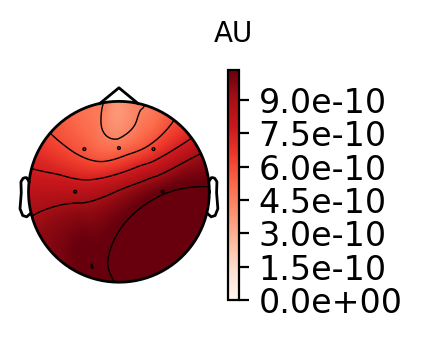

In [35]:
# Plot the TFR for channel 'Cz'
avgpower.plot([epochs.ch_names.index('F3')], title='TFR for F3')

# Plot topographical map for alpha band (8-12 Hz)
avgpower.plot_topomap(tmin=0.1, tmax=0.3, fmin=8, fmax=12)
